In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ucimlrepo import fetch_ucirepo

import keras
from keras.models import Model
from keras.layers import Dense, Input
from keras import optimizers, losses, metrics
import kdm

In [2]:
# Configuración inicial
os.environ["KERAS_BACKEND"] = "torch"

# Cargar el dataset de Combined Cycle Power Plant (CCPP)
combined_cycle_power_plant = fetch_ucirepo(id=294)
X = combined_cycle_power_plant.data.features
y = combined_cycle_power_plant.data.targets

In [3]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalamiento de características
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

In [4]:
scaler_y = MinMaxScaler((0.2, np.pi / 2 - 0.2))
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [16]:
input_dim = X_train.shape[1]  # Número de características de entrada
encoded_size = 10  # Ajustar según experimentos

encoder_input = Input(shape=(input_dim,))
encoded = Dense(encoded_size, activation='relu')(encoder_input)
encoder_model = Model(encoder_input, encoded)



In [19]:
# Definir dim_y como la dimensión de la variable objetivo y
dim_y = 1

# Definir n_comp como el número de componentes
n_comp = 5  # Ajustar según experimentos

kdm_model = kdm.models.KDMRegressModel(
    encoded_size=encoded_size,
    dim_y=dim_y,
    encoder=encoder_model,
    n_comp=n_comp,
    sigma=0.1
)


In [20]:
# Compilar modelo
kdm_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=losses.mean_squared_error,
    metrics=[metrics.mean_squared_error]
)

In [21]:
# Inicializar componentes
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
kdm_model.init_components(X_train[indices], y_train[indices], init_sigma=True)

# Entrenamiento del modelo
history = kdm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)



Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.00

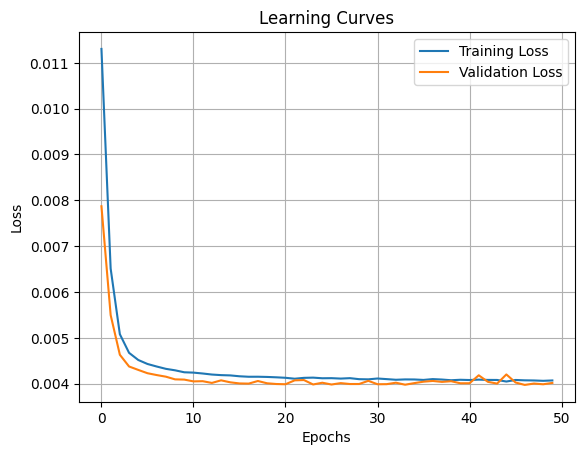

In [22]:
# Graficar la pérdida durante el entrenamiento
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Evaluación en el conjunto de prueba
y_pred = kdm_model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R^2: {r2}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MSE: 17.17520334170207
Test MAE: 3.200674510970426
Test R^2: 0.9414134798277664


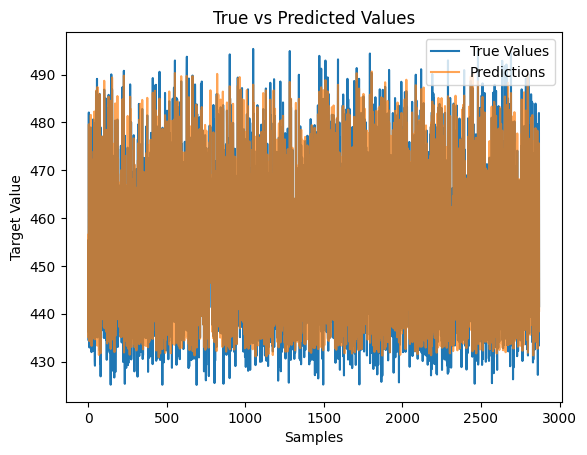

In [24]:
# Visualización de resultados
plt.figure()
plt.plot(y_test_rescaled, label='True Values')
plt.plot(y_pred_rescaled, label='Predictions', alpha=0.7)
plt.title('True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Target Value')
plt.legend()
plt.show()